In [54]:
pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.4/789.4 kB 68.0 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 75.2 kB/s eta 0:00:0000:0100:04m 8.6/9.1 MB 75.1 kB/s eta 0:00:07
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 73.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.6/252.6 kB 119.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 70.2 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 66.5 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
from ltrcart import LTRCart
from survival_data import SurvivalData
import pandas as pd
import sys
from lifelines import CoxPHFitter
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import graphviz 
from sklearn import tree
from matplotlib import pyplot as plt

import numpy as np
from sksurv.datasets import load_gbsg2
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import integrated_brier_score

In [2]:
train = pd.read_csv('/Users/tomer/PycharmProjects/LTRCSurvivalTree/sample_data/creatinine_train.csv',index_col=0)
test = pd.read_csv('/Users/tomer/PycharmProjects/LTRCSurvivalTree/sample_data/creatinine_test.csv',index_col=0)

In [3]:
train.head()

,age,sex,sample.yr,kappa,lambda,FLC,creatinine,mgus,futime,death,chapter,End
1,97,F,1997,5.70,4.860,10,1.7,0,85,1,Circulatory,97.232877
2,92,F,2000,0.87,0.683,1,0.9,0,1281,1,Neoplasms,95.509589
3,94,F,1997,4.36,3.850,10,1.4,0,69,1,Circulatory,94.189041
4,92,F,1996,2.42,2.220,9,1.0,0,115,1,Circulatory,92.315068
5,93,F,1996,1.32,1.690,6,1.1,0,1039,1,Circulatory,95.846575


In [4]:
y_train = SurvivalData(train[['age','End','death']])
y_test = SurvivalData(test[['age','End','death']])

In [5]:
x_train = train.loc[:,['sex' , 'FLC' , 'creatinine']]
x_test = test.loc[:,['sex' , 'FLC' , 'creatinine']]

x_train = x_train.replace({'F':0,'M':1})
x_test = x_test.replace({'F':0,'M':1})

In [6]:
ltrc_art_obj =  LTRCart(y_train,x_train)
ltrc_art_tree = ltrc_art_obj.ltrc_art_fit()
ltrc_art_predict = ltrc_art_tree.predict(x_test)
pd.DataFrame(ltrc_art_predict).head(6)

,0
0,0.451636
1,0.451636
2,0.451636
3,0.451636
4,0.606902
5,0.451636


[Text(0.6, 0.875, 'creatinine <= 1.95\npoisson = 0.281\nsamples = 500\nvalue = 0.394'),
 Text(0.4, 0.625, 'FLC <= 2.5\npoisson = 0.286\nsamples = 474\nvalue = 0.408'),
 Text(0.2, 0.375, 'poisson = 0.432\nsamples = 32\nvalue = 0.607'),
 Text(0.6, 0.375, 'sex <= 0.5\npoisson = 0.272\nsamples = 442\nvalue = 0.393'),
 Text(0.4, 0.125, 'poisson = 0.313\nsamples = 257\nvalue = 0.452'),
 Text(0.8, 0.125, 'poisson = 0.2\nsamples = 185\nvalue = 0.312'),
 Text(0.8, 0.625, 'poisson = 0.094\nsamples = 26\nvalue = 0.149')]

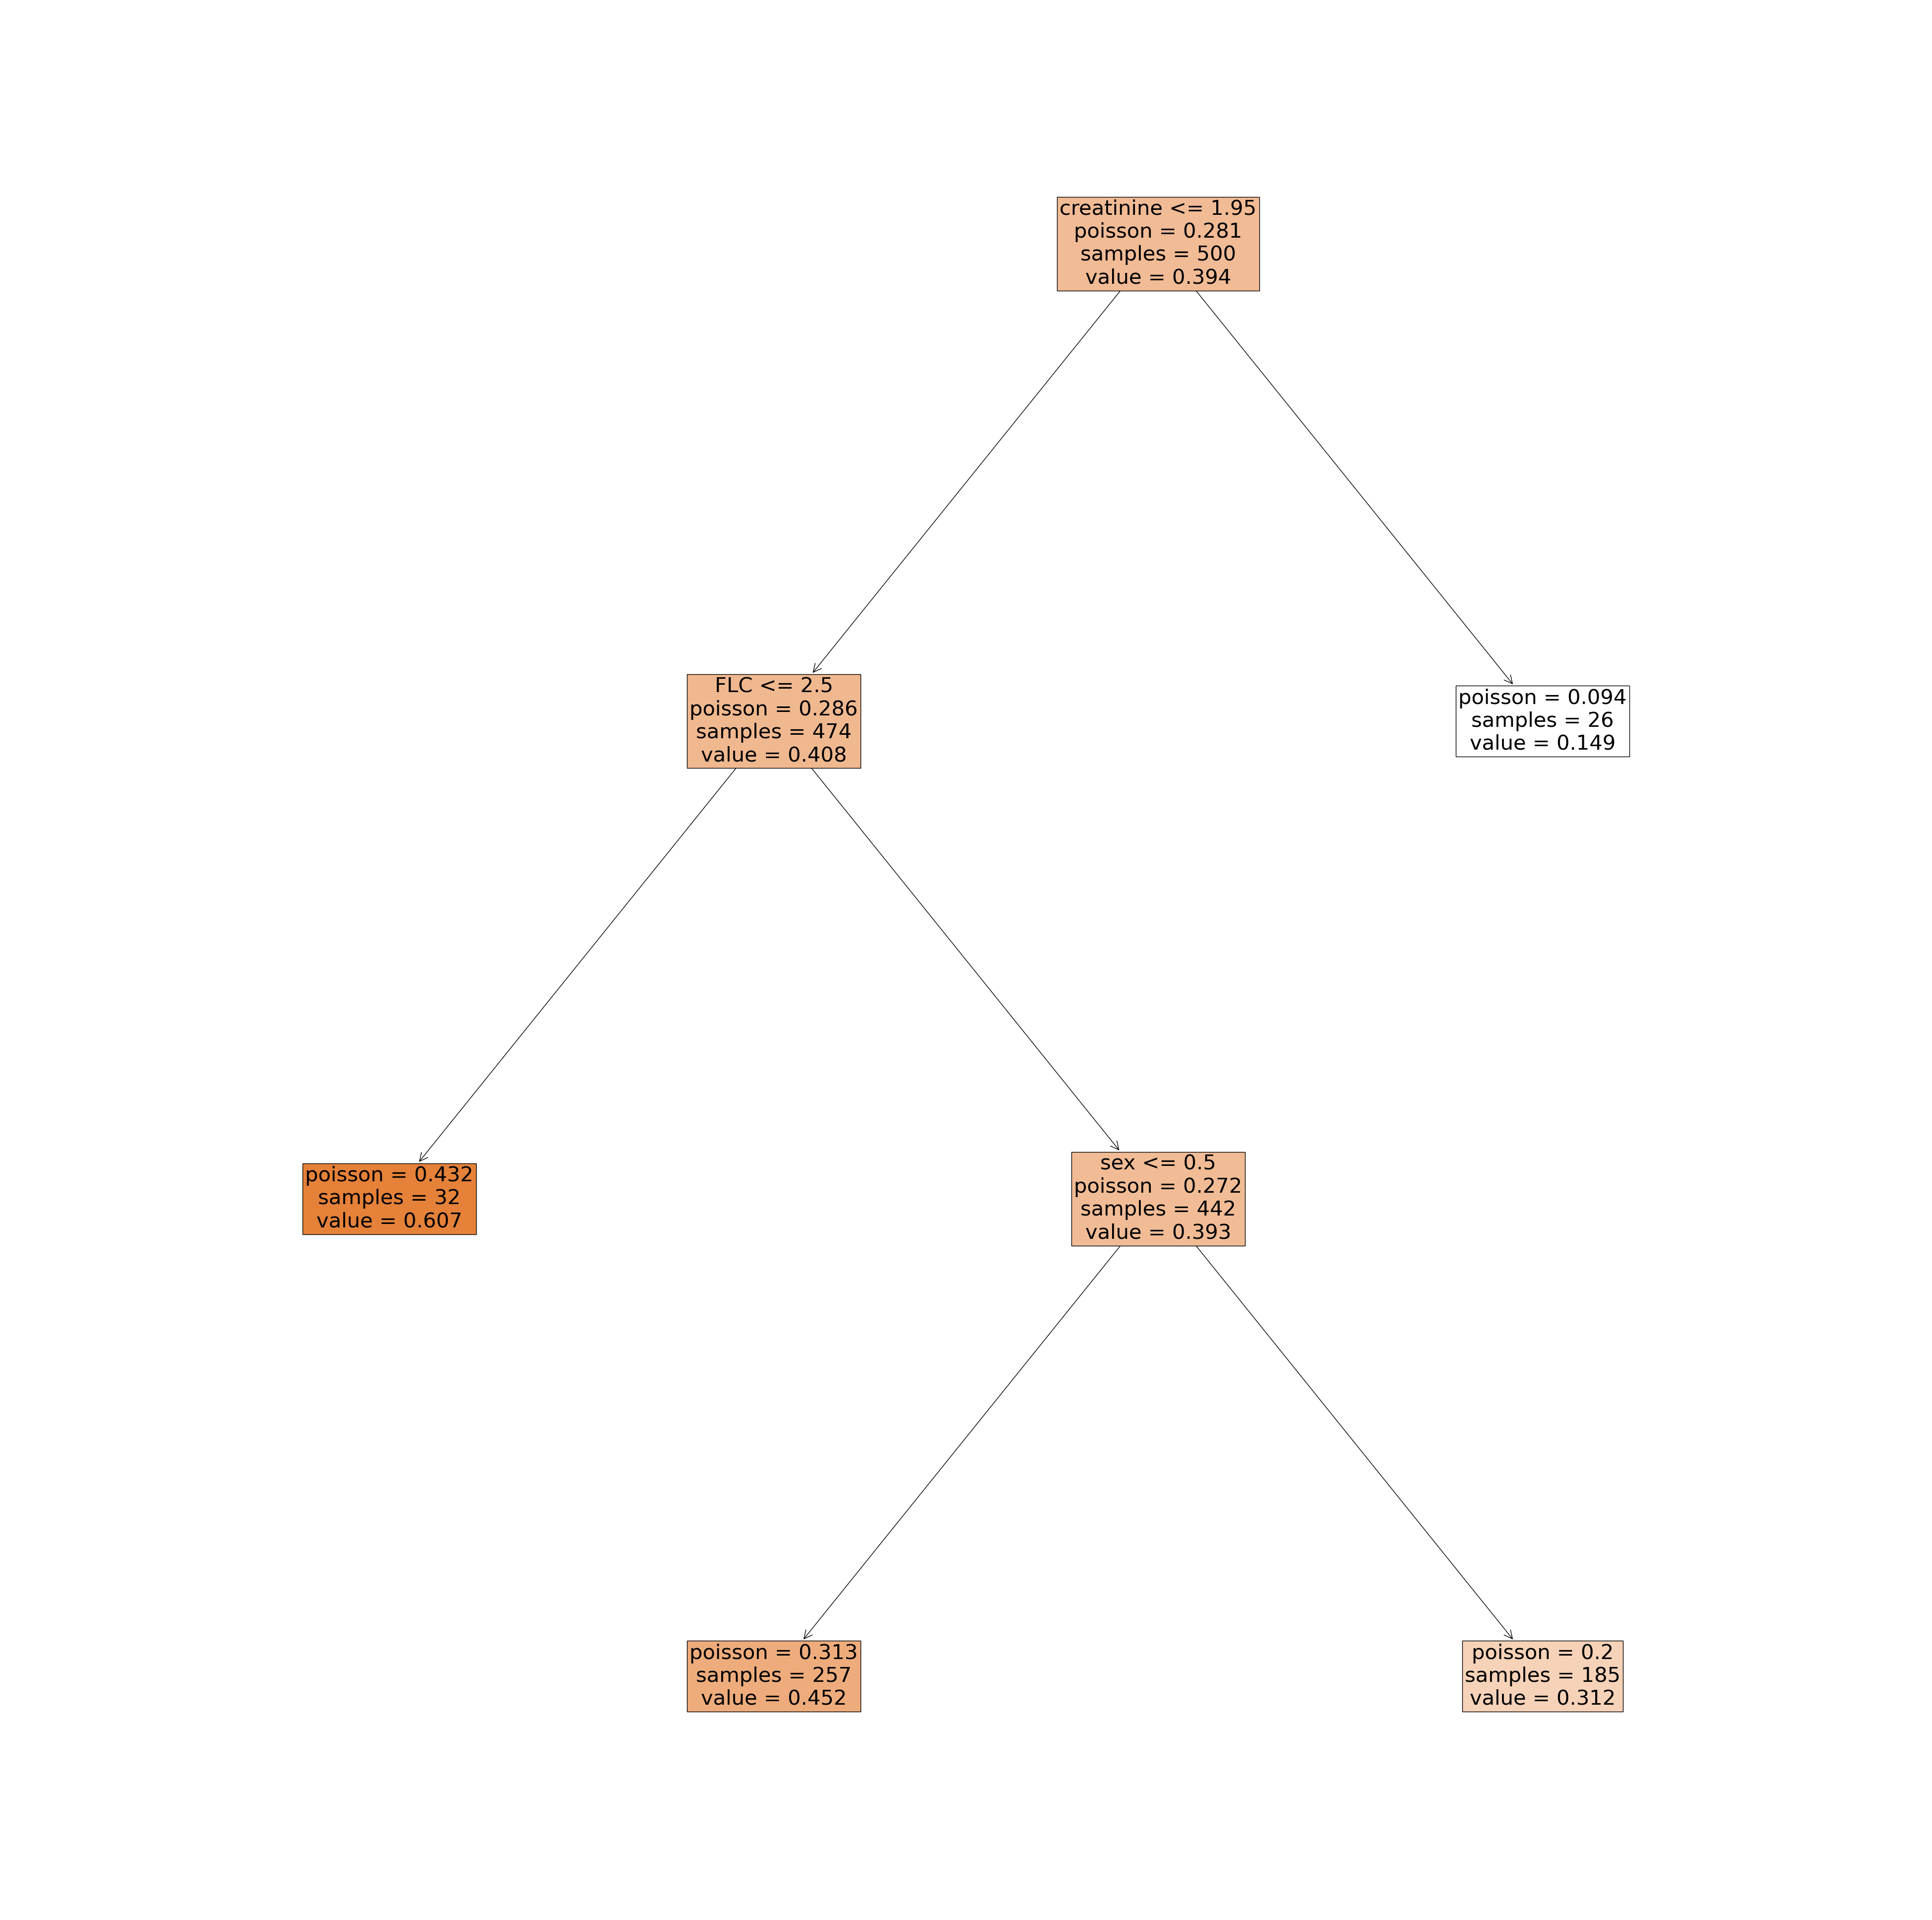

In [7]:
fig = plt.figure(figsize=(50,50))
tree.plot_tree(ltrc_art_tree,fontsize=30,feature_names=x_train.columns,filled = True)

In [8]:
def create_sim_data(dist = np.random.exponential,dist_values=[0.1,0.23,0.4,0.9],lt=1 ,heavy = False):
    x_1, x_4 = np.random.randint(1,6,10000), np.random.randint(1,6,10000)
    x_2, x_5 = np.random.randint(1,3,10000), np.random.randint(1,3,10000)
    x_3, x_6 = np.random.rand(10000)*2, np.random.rand(10000)*2
    sim_data = pd.DataFrame({'x_1':x_1,'x_2':x_2,'x_3':x_3,'x_4':x_4,'x_5':x_5,'x_6':x_6})

    sim_data['lt'] = np.random.rand(10000)*lt

    t_1=dist(dist_values[0],10000)*((sim_data.x_1<=2) & (sim_data.x_2==1))
    t_2=dist(dist_values[1],10000)*((sim_data.x_1<=2) & (sim_data.x_2==2))
    t_3=dist(dist_values[2],10000)*((sim_data.x_1>2) & (sim_data.x_3<=1))
    t_4=dist(dist_values[3],10000)*((sim_data.x_1>2) & (sim_data.x_3>1))

    sim_data['t'] = pd.DataFrame([t_1,t_2,t_3,t_4]).max()
    sim_data = sim_data.loc[sim_data['t']>=sim_data['lt']]
    prop_cens = 0
    c=3
    min_cens = 0.5 if heavy else 0.2
    while prop_cens<=min_cens:
        sim_data['c'] = sim_data['lt']+np.random.exponential(scale=c,size=sim_data.shape[0])
        prop_cens = (sim_data['c']<sim_data['t']).sum()/sim_data.shape[0]
        c-=0.02
    sim_data['event'] = (sim_data['c']>sim_data['t']).astype(int)
    sim_data['t'] = sim_data[['t','c']].min(axis=1)
    return sim_data[['lt','t','event']],sim_data[['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6']]

[Text(0.5, 0.5, 'poisson = 0.362\nsamples = 500\nvalue = 0.429')]

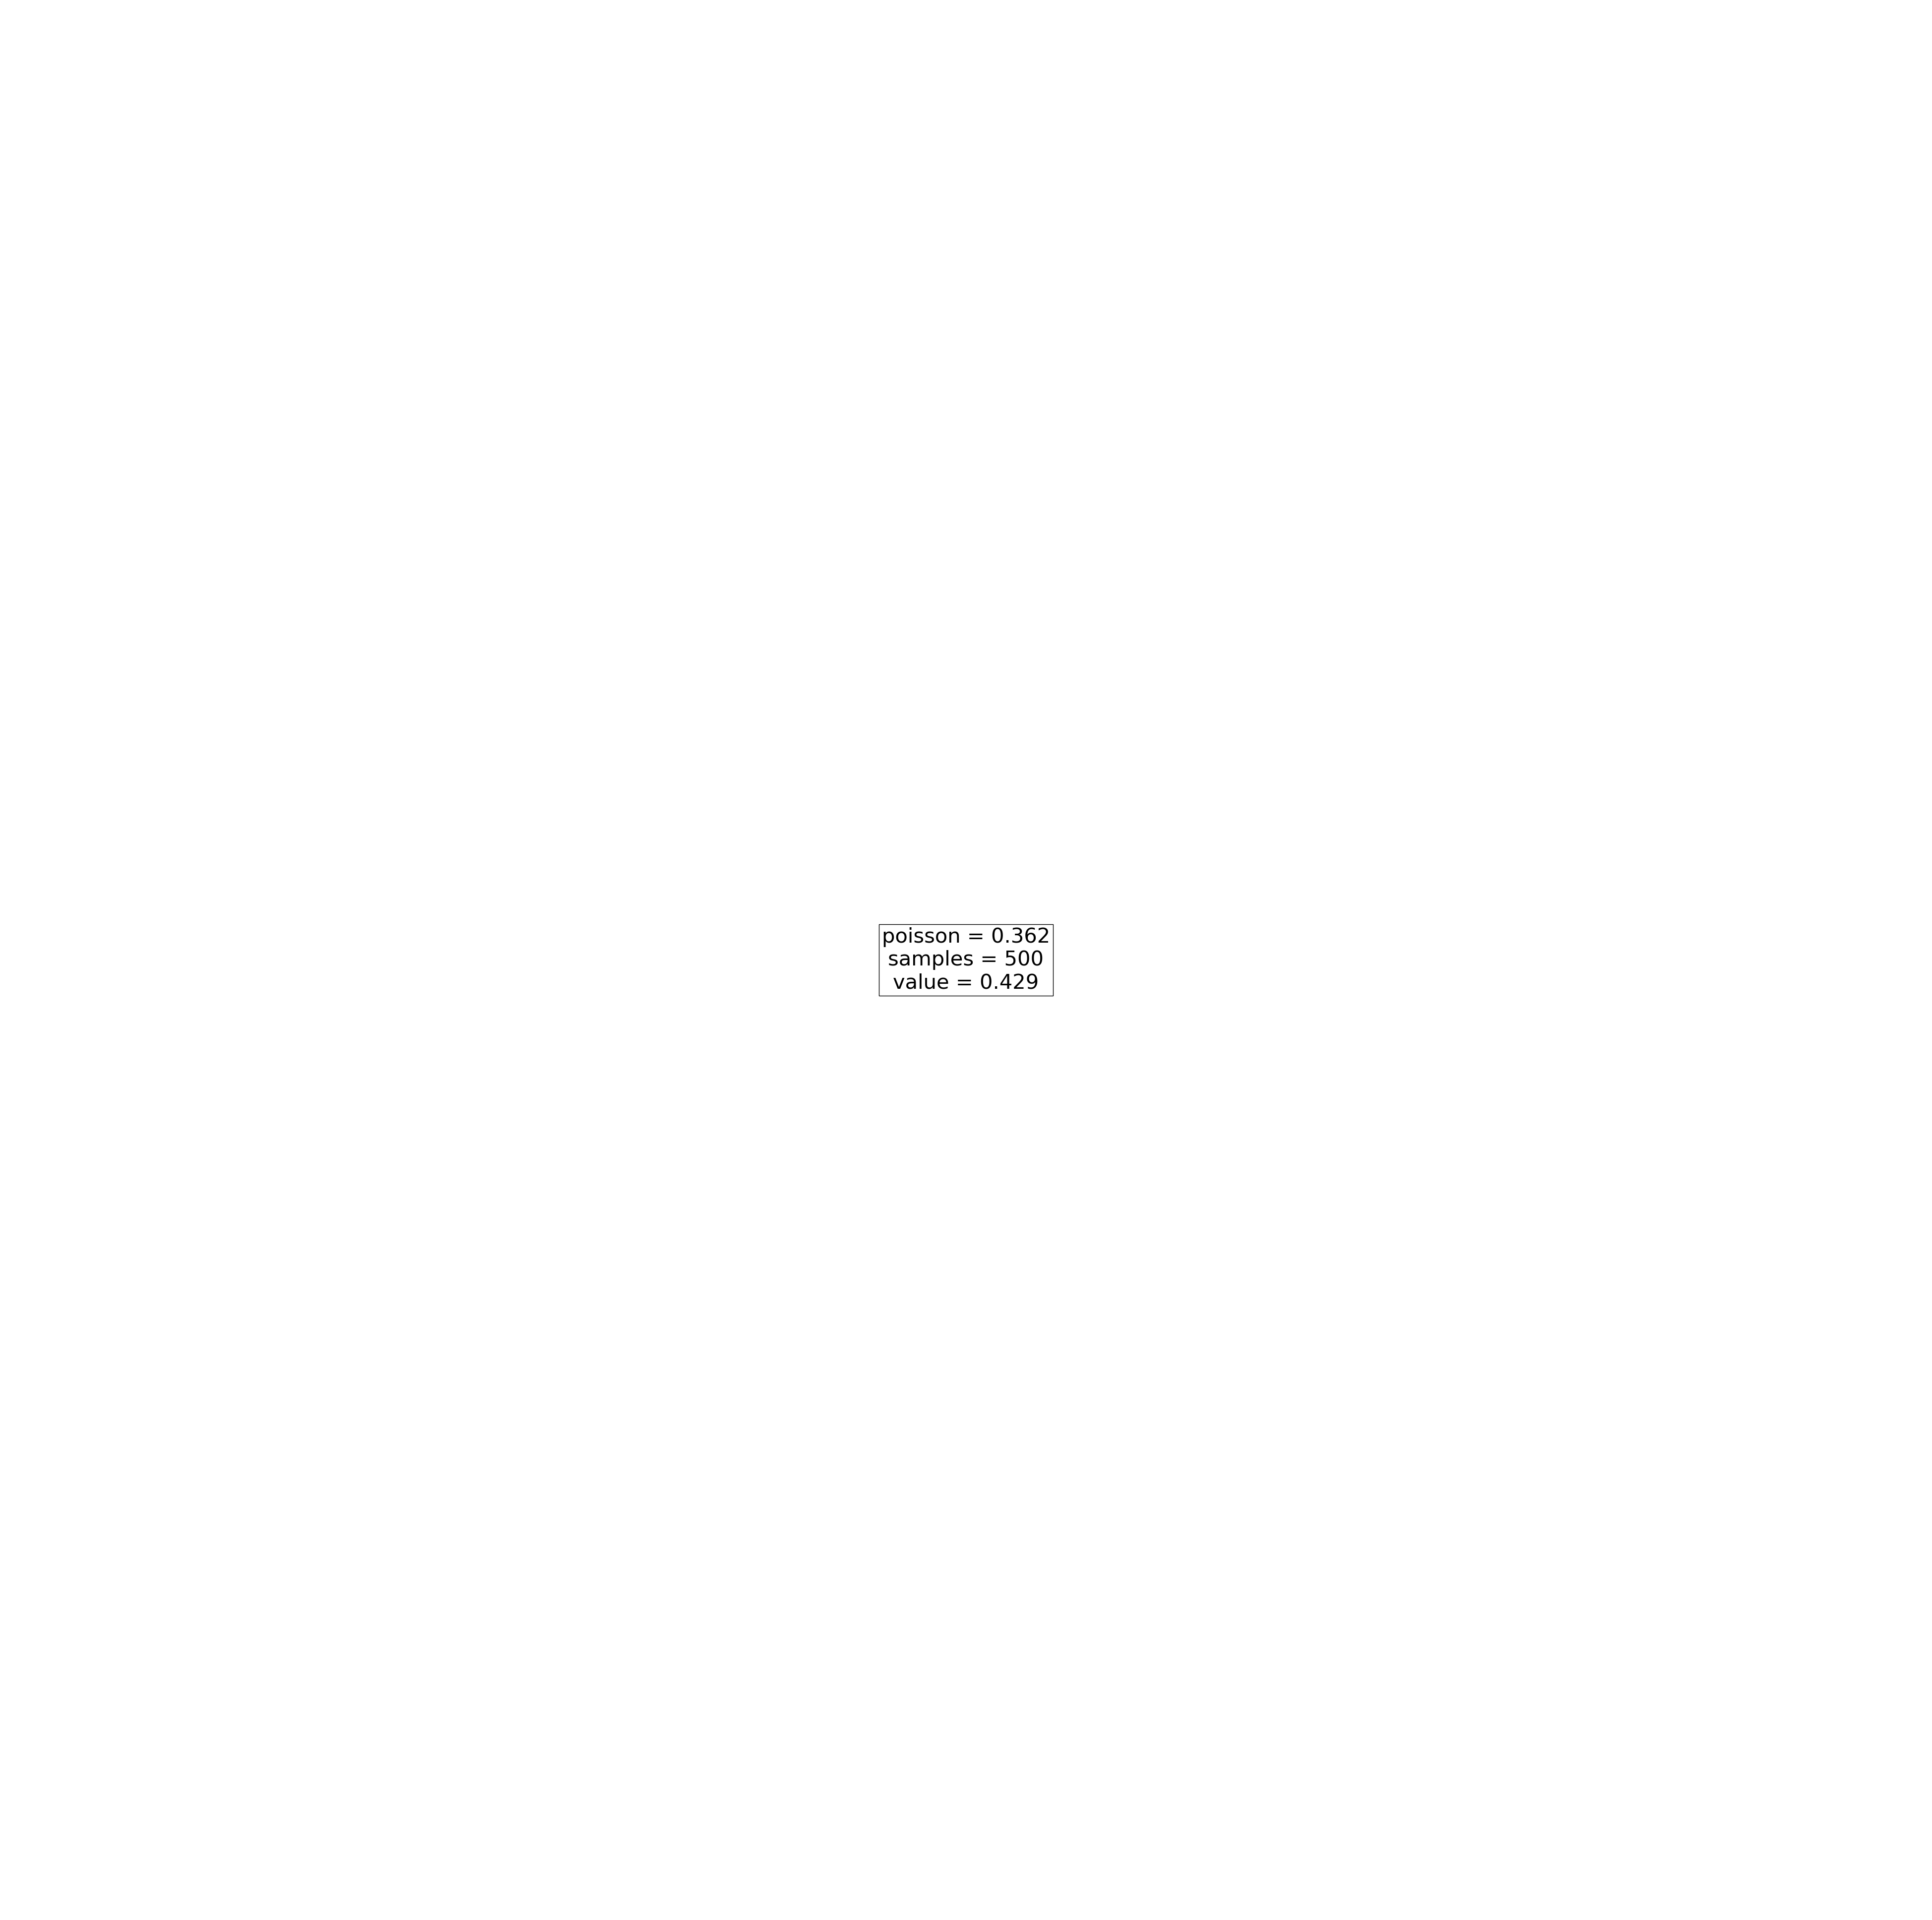

In [28]:
y_light,x_light = create_sim_data()
y_light,x_light = y_light.iloc[:500],x_light.iloc[:500]
surv_data = SurvivalData(y_light)
ltrc_art_tree =LTRCart(surv_data,x_light)
ltrc_art_tree = ltrc_art_tree.ltrc_art_fit()
fig = plt.figure(figsize=(50,50))
tree.plot_tree(ltrc_art_tree,fontsize=30,filled = True)

In [10]:
def printTree(root, markerStr="+- ", levelMarkers=[]):
    emptyStr = " "*len(markerStr)
    connectionStr = "|" + emptyStr[:-1]
    level = len(levelMarkers)
    mapper = lambda draw: connectionStr if draw else emptyStr
    markers = "".join(map(mapper, levelMarkers[:-1]))
    markers += markerStr if level > 0 else ""
    print(f"{markers}{root.x}")
    for i, child in enumerate(root.children):
        isLast = i == len(root.children) - 1
        printTree(child, markerStr, [*levelMarkers, not isLast])

# Brier score

In [55]:
y, X = create_sim_data()
new_y = y[['event','t']].to_numpy()
#List of tuples
aux = [(e1,e2) for e1,e2 in new_y]

#Structured array
new_y= np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

est = CoxPHSurvivalAnalysis(ties="efron").fit(X, new_y)
survs = est.predict_survival_function(X)
times = y.t.loc[:300]
preds = np.asarray([[fn(t) for t in times] for fn in survs])
score = integrated_brier_score(new_y, new_y, preds, times)
print(score)

0.34242921921720376


,lt,t,event
2,0.022132,0.168019,1
7,0.112242,0.611217,1
8,0.075233,0.093641,0
14,0.132082,1.041465,1
15,0.129349,0.246172,1
...,...,...,...
9994,0.065670,0.831214,1
9996,0.493395,0.578973,1
9997,0.367729,0.486848,1
9998,0.915571,2.851624,1


In [46]:
preds

array([[9.99835327e-01, 5.06625836e-01, 1.70196741e-01, 5.72053912e-02,
        1.92561794e-02],
       [9.99595208e-01, 1.87925761e-01, 1.28625239e-02, 8.81477828e-04,
        6.06301024e-05],
       [9.99865717e-01, 5.74368523e-01, 2.35986902e-01, 9.69987288e-02,
        3.99183091e-02],
       ...,
       [9.99772921e-01, 3.91525435e-01, 8.69904796e-02, 1.93414646e-02,
        4.30923144e-03],
       [9.99725102e-01, 3.21358076e-01, 5.20126293e-02, 8.42555872e-03,
        1.36826269e-03],
       [9.99648957e-01, 2.34641349e-01, 2.29306878e-02, 2.24337832e-03,
        2.20175138e-04]])

In [47]:
times

array([0, 1, 2, 3, 4])